In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Classifier made using FastAI: "Is it a bird" notebook

In [2]:
#NB: Kaggle requires phone verification to use the internet or a GPU. If you haven't done that yet, the cell below will fail
#    This code is only here to check that your internet is enabled. It doesn't do anything else.
#    Here's a help thread on getting your phone number verified: https://www.kaggle.com/product-feedback/135367

import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [3]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Download images of the emotions we want to classify (anger, sadness, fear, anxiety, disgust, calmness and happiness)

In [4]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images = 50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results = max_images)).itemgot('image')

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('sad person face', max_images=1)
urls[0]

Searching for 'sad person face'


'http://cliparts.co/cliparts/8Tx/rja/8Txrjakoc.jpg'

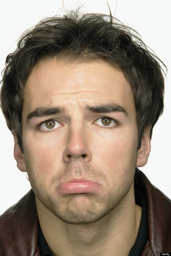

In [6]:
from fastdownload import download_url
dest = 'sad.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'angry person face'


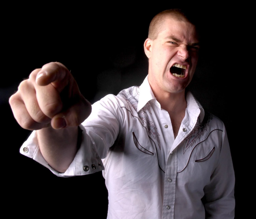

In [7]:
download_url(search_images('angry person face', max_images=1)[0], 'angry.jpg', show_progress=False)
Image.open('angry.jpg').to_thumb(256,256)

In [8]:
searches = 'angry','sad', 'scared', 'anxious', 'disgusted', 'calm', 'happy'
path = Path('emotion_classifier')
for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} person face'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'angry person face'
Searching for 'sad person face'
Searching for 'scared person face'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Searching for 'anxious person face'
Searching for 'disgusted person face'
Searching for 'calm person face'
Searching for 'happy person face'


## Step 2: Clean the dataset and train our model

In [9]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [10]:
get_image_files

<function fastai.data.transforms.get_image_files(path, recurse=True, folders=None)>

<function CategoryBlock at 0x7f1194a3d290>


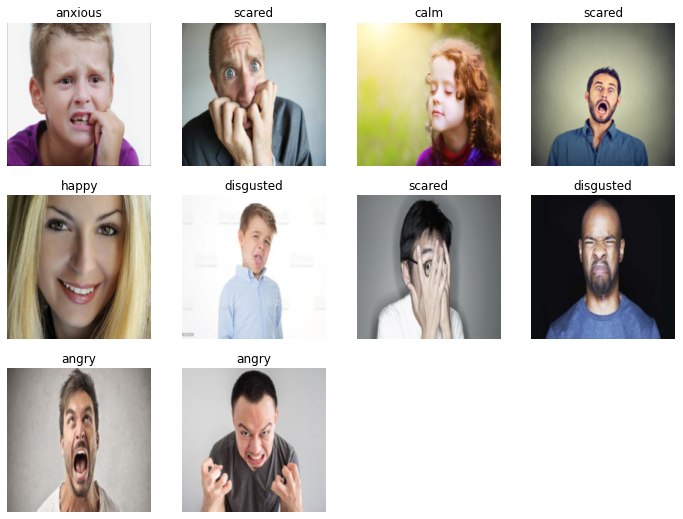

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.15, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=10)
print(CategoryBlock)

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.948846,0.457677,0.150485,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.498323,0.107614,0.029126,00:10
1,0.246276,0.024020,0.009709,00:09
2,0.128775,0.002707,0.000000,00:09
3,0.075282,0.004288,0.000000,00:09
4,0.044201,0.001416,0.000000,00:09
5,0.026809,0.001199,0.000000,00:08
6,0.016086,0.001223,0.000000,00:09
7,0.010700,0.001586,0.000000,00:09
8,0.006765,0.001942,0.000000,00:09
9,0.006270,0.001533,0.000000,00:09


#### We have 100% of accurracy, that's perfect!

## Step 3: Use the model

### Detection of angry people

In [ ]:
classes = ['angry', 'anxious', 'calm', 'disgusted','happy', 'sad', 'scared']

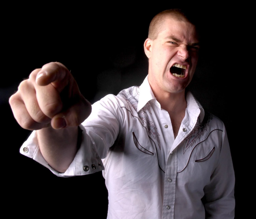

In [14]:
image = PILImage.create('angry.jpg')
image.to_thumb(256,256)

In [15]:
emotion_classif,s,probs = learn.predict(PILImage.create('angry.jpg'))
print(f"This is an: angry person")

print("""
Predictions:
""")
for i in range(len(os.listdir(path))):
    print(f"Possibility of being an {classes[i]} person: {probs[i]*100} %")

This is an: angry person

Predictions:

Possibility of being an angry person: 99.99768829345703 %
Possibility of being an anxious person: 0.000567482435144484 %
Possibility of being an calm person: 2.2586425984627567e-05 %
Possibility of being an disgusted person: 0.000347779830917716 %
Possibility of being an happy person: 0.0008648701477795839 %
Possibility of being an sad person: 0.00025660410756245255 %
Possibility of being an scared person: 0.00023751947446726263 %


### Detection of happy people

Searching for 'happy person face'


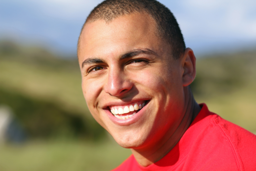

In [16]:
download_url(search_images('happy person face', max_images=1)[0], 'happy.jpg', show_progress=False)
Image.open('happy.jpg').to_thumb(256,256)

In [17]:
emotion_classif,s,probs = learn.predict(PILImage.create('happy.jpg'))
print(f"This is an: happy person")
print("""
Predictions:
""")
for i in range(len(os.listdir(path))):
    print(f"Possibility of being an {classes[i]} person: {probs[i]*100} %")

This is an: happy person

Predictions:

Possibility of being an angry person: 0.004104262217879295 %
Possibility of being an anxious person: 1.1119008377136197e-05 %
Possibility of being an calm person: 1.243617862201063e-05 %
Possibility of being an disgusted person: 9.414790838491172e-06 %
Possibility of being an happy person: 99.99058532714844 %
Possibility of being an sad person: 0.005277460906654596 %
Possibility of being an scared person: 9.81742800831853e-07 %


### Detection of scared people

Searching for 'scared person face'


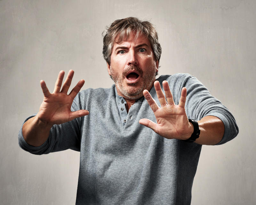

In [18]:
download_url(search_images('scared person face', max_images=1)[0], 'scared.jpg', show_progress=False)
Image.open('scared.jpg').to_thumb(256,256)

In [19]:
emotion_classif,s,probs = learn.predict(PILImage.create('scared.jpg'))
print(f"This is an: scared person")
print("""
Predictions:
""")
for i in range(len(os.listdir(path))):
    print(f"Possibility of being an {classes[i]} person: {probs[i]*100} %")

This is an: scared person

Predictions:

Possibility of being an angry person: 0.0003019630385097116 %
Possibility of being an anxious person: 2.5753211957635358e-05 %
Possibility of being an calm person: 2.8576974727911875e-05 %
Possibility of being an disgusted person: 7.397149602184072e-05 %
Possibility of being an happy person: 4.305561014916748e-05 %
Possibility of being an sad person: 3.9382106479024515e-05 %
Possibility of being an scared person: 99.9994888305664 %


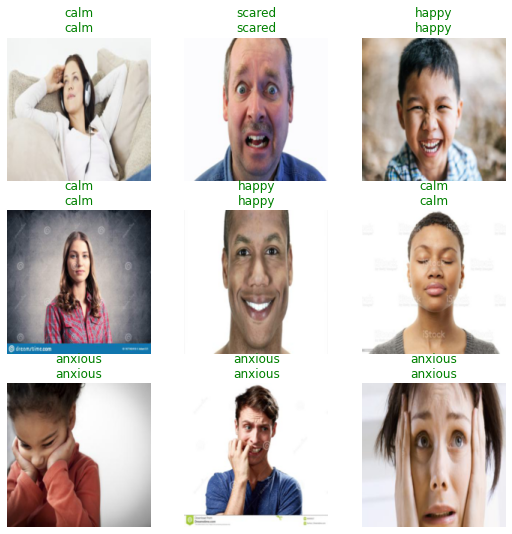

In [20]:
learn.show_results()